In [1]:
import time
start_time = time.perf_counter()

In [2]:
%matplotlib inline
# version check
import numpy
print('The numpy version is {}.'.format(numpy.__version__))
import pandas
print('The pandas version is {}.'.format(pandas.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import matplotlib
print('The matplotlib version is {}.'.format(matplotlib.__version__))
import regex
print('The regex version is {}.'.format(regex.__version__))

The numpy version is 1.18.1.
The pandas version is 1.0.4.
The scikit-learn version is 0.23.1.
The matplotlib version is 3.2.1.
The regex version is 2.5.80.


In [3]:
# set random state for reproducibility
random_state = 42

# default numpy settings
import numpy as np
np.set_printoptions(edgeitems=3)
np.core.arrayprint._line_width = 80

# update settings
import numpy as np
np.set_printoptions(edgeitems=15, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# update pandas settings
import pandas as pd
pd.set_option('max_colwidth', 200)
pd.options.display.max_rows = 250

## Import data

In [4]:
%%time
Dataset_directory = './data/enron/clean_clean_outliers.csv'
df = pd.read_csv(Dataset_directory, index_col=0)

Wall time: 6.31 s


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138262 entries, 0 to 138261
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   f_dir               138262 non-null  object 
 1   m_id                138262 non-null  object 
 2   m_date              138262 non-null  object 
 3   m_from              138262 non-null  object 
 4   m_to                136003 non-null  object 
 5   m_cc                44558 non-null   object 
 6   m_bcc               42520 non-null   object 
 7   m_subj              132469 non-null  object 
 8   mime_vers           138262 non-null  float64
 9   cont_type           138262 non-null  object 
 10  encode              138262 non-null  object 
 11  x_from              138262 non-null  object 
 12  x_to                136579 non-null  object 
 13  x_cc                42818 non-null   object 
 14  x_bcc               116 non-null     object 
 15  x_fold              138262 non-nul

In [6]:
# global variable for the series containing the corpus, target 
Corpus_series = 'preprocessed_body'
Target_series = 'gender'

In [7]:
df.groupby([Target_series]).size()

gender
0.0    76597
1.0    61665
dtype: int64

In [8]:
df.head(2)

,f_dir,m_id,m_date,m_from,m_to,m_cc,m_bcc,m_subj,mime_vers,cont_type,...,x_fname,o_body,m_body,gender,n_emails_sent,n_characters_start,clean_char,n_char,clean_body,preprocessed_body
0,./data/enron/maildir/dasovich-j/all_documents/10019,<30982749.1075843392750.JavaMail.evans@thyme>,"Thu, 15 Mar 2001 04:37:00 -0800 (PST)",alan.comnes@enron.com,"james.steffes@enron.com, jeff.dasovich@enron.com, sandra.mccubbin@enron.com",NaN,NaN,Per today's call,1.0,text/plain; charset=us-ascii,...,jdasovic.nsf\n\n,"Message-ID: <30982749.1075843392750.JavaMail.evans@thyme>\nDate: Thu, 15 Mar 2001 04:37:00 -0800 (PST)\nFrom: alan.comnes@enron.com\nTo: james.steffes@enron.com, jeff.dasovich@enron.com, sandra.mc...",My recollection is that this sheet is a bit vague on detail.\n\nCalifornia's gas problems are twofold:\n\nWellhead prices are still high. CERA is the best place to get more data on \ndrilling act...,0.0,645,360,233,360,My recollection is that this sheet is a bit vague on detail.\n\nCalifornia's gas problems are twofold:\n\nWellhead prices are still high. CERA is the best place to get more data on \ndrilling act...,recollection sheet bit vague detail california gas problem twofold wellhead price still high cera get data drilling activity etc instate capacity tigh pg sdg cec study event california utiilties p...
1,./data/enron/maildir/hayslett-r/action_items_in/19,<17193631.1075844275678.JavaMail.evans@thyme>,"Mon, 6 Nov 2000 03:34:00 -0800 (PST)",lisa.lunz@enron.com,"rod.hayslett@enron.com, danette.campbell@enron.com","karry.kendall@enron.com, karen.gruesen@enron.com, jane.coleman@enron.com,","karry.kendall@enron.com, karen.gruesen@enron.com, jane.coleman@enron.com,","Re: Jane Coleman, case 262558.",1.0,text/plain; charset=us-ascii,...,rhaysle.nsf\n\n,"Message-ID: <17193631.1075844275678.JavaMail.evans@thyme>\nDate: Mon, 6 Nov 2000 03:34:00 -0800 (PST)\nFrom: lisa.lunz@enron.com\nTo: rod.hayslett@enron.com, danette.campbell@enron.com\nSubject: R...",Please read below regarding Jane Coleman and her FERC Request. Contact Karen \nGruesen @ 3-6571 for further information as to why Jane needs this role.\n\nThanks\nLisa Lunz\n3-5634\n-------------...,1.0,25,3629,71,177,Please read below regarding Jane Coleman and her FERC Request. Contact Karen \nGruesen @ 3-6571 for further information as to why Jane needs this role.\n\nThanks\nLisa Lunz\n3-5634\n,please read regarding ferc request contact information need role thanks


# Evaluating Classifiers

## Randomize dataframe

In [9]:
def resample_frame(df, n=len(df), random_state=random_state):
    df = df.sample(n=n, random_state=random_state).reset_index(drop=True)
    return df
df = resample_frame(df) # resampled

In [10]:
def plot_multi(df, n_samples=1000, run_these=[], CV=5):
    
    import numpy as np
    
    X = df[Corpus_series].values[:n_samples]
    y = df[Target_series].values[:n_samples]

    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(min_df=7, max_df=.7, token_pattern=r"\w{4,13}", stop_words=None)
    X = vect.fit_transform(X)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import LinearSVC
    from sklearn.neighbors import KNeighborsClassifier

    name_dict = {
        'RandomForestClassifier':'RFC',
        'LinearSVC': 'LSVC',
        'MultinomialNB':'MNB',
        'LogisticRegression':'LOGR',
        'SGDClassifier':'SGDC',
        'KNeighborsClassifier':'KNN',
    }
    models = [
        LogisticRegression(random_state=42),
        SGDClassifier(),
        LinearSVC(),
        RandomForestClassifier(max_depth=25, random_state=42),
        MultinomialNB(),
        KNeighborsClassifier(),
    ]
    
    # create dataframe, list for data catch
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []

    from sklearn.model_selection import cross_val_score # loop models, return accuracy
    for model in models:
        model_name = name_dict[model.__class__.__name__]
        if model_name in run_these:
            accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV, n_jobs=-1)
            for fold_idx, accuracy in enumerate(accuracies):
                entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        sns.boxplot(x='model_name', y='accuracy', data=cv_df)
        sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                      size=8, jitter=True, edgecolor="gray", linewidth=2)
        plt.title('n_samples: {}'.format(n_samples))
        plt.grid(axis='y', which='both')
        plt.xlabel('Classifiers')

## Evaluate classifiers across multiple cv iterations, resampling

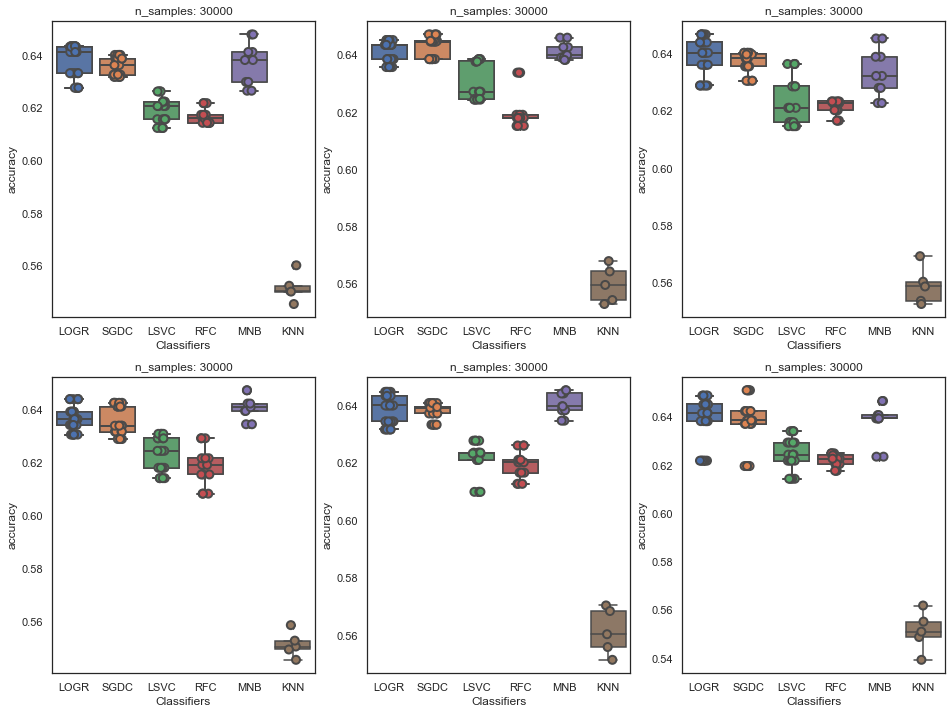

Wall time: 43.7 s


In [11]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
iter_ct = 6
iter_this = np.linspace(1,iter_ct,iter_ct)

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

run_these = ['RFC','LSVC','MNB','LOGR','SGDC','KNN']

plt.figure(figsize=(16,12), facecolor='w', edgecolor='k')
for x in iter_this:
    plt.subplot(2, 3, x)
    plot_multi(df, n_samples=30000, run_these=run_these)
    df = resample_frame(df)
plt.show()

## Variance across sample count

[ 60000  75652  91304 106957 122609 138262]


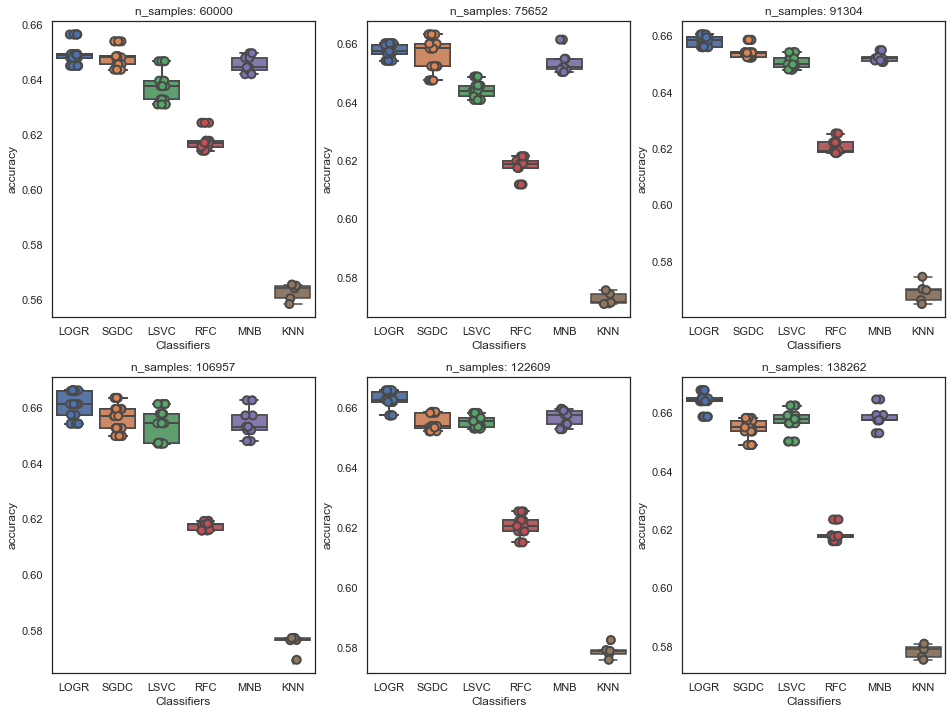

Wall time: 3min 58s


In [12]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
iter_ct = 6
iter_this = np.linspace(1,iter_ct,iter_ct)

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

run_these = ['RFC','LSVC','MNB','LOGR','SGDC','KNN']

sample_nums = np.linspace(60000, len(df), iter_ct).astype('int32')
#sample_nums = np.linspace(4000, 11000, iter_ct).astype('int32')
print(sample_nums)
x=1
plt.figure(figsize=(16,12), facecolor='w', edgecolor='k')
for sample_count in sample_nums:
    plt.subplot(2, 3, x)
    plot_multi(df, n_samples=sample_count, run_these=run_these)
    df = resample_frame(df)
    x+=1
plt.show()

# Linear support vector classification (LSVC): GridSearchCV

In [13]:
def lsvc_gridsearchcv(df, n=5000, cv_n=10, test_size=0.3, random_state=random_state):
    
    X = df[Corpus_series].values[:n]
    y = df[Target_series].values[:n]
    
    # setup pipeline, instatiate gridsearch object
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.svm import LinearSVC
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    steps = [
        ('vect', TfidfVectorizer()),
        ('lsvc', LinearSVC())
    ]
    pipeline = Pipeline(steps) 
    c_space = np.logspace(-5,4, 10)
    parameters = {
        'vect__min_df':[7],
        'vect__max_df':[.7],
        'vect__token_pattern':[r"\w{4,13}"],
        'vect__stop_words':[None],
#        'lsvc__penalty': ['l1', 'l2'],
        'lsvc__C':c_space,
#        'lsvc__tol':[1e-4],
        'lsvc__class_weight':['balanced'],
        'lsvc__max_iter':[1000],
    }
    lsvc_cv = GridSearchCV(pipeline, param_grid=parameters, cv=cv_n, n_jobs=-1)
    
    # train, fit
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    lsvc_cv.fit(X_train, y_train)
    print('Tuned LSVC Parameters: {}'.format(lsvc_cv.best_params_))
    print('Tuned LSVC Accuracy: {}'.format(lsvc_cv.best_score_))
    
    return lsvc_cv.best_params_

def lsvc_best_run(lsvc_best, n=5000, test_size=0.3, random_state=random_state):
    # get smaller sample
    X = df[Corpus_series].values[:n]
    y = df[Target_series].values[:n]

    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(        
        min_df=lsvc_best['vect__min_df'],
        max_df=lsvc_best['vect__max_df'],
        token_pattern=lsvc_best['vect__token_pattern'],
        stop_words=lsvc_best['vect__stop_words'],
    )
    X = vect.fit_transform(X)
    from sklearn.svm import LinearSVC
    model = LinearSVC(
#        penalty=lsvc_best['lsvc__penalty'],
        C=lsvc_best['lsvc__C'],
#        tol=lsvc_best['lsvc__tol'],
        class_weight=lsvc_best['lsvc__class_weight'],
        max_iter=lsvc_best['lsvc__max_iter'],
    )
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    from sklearn.metrics import plot_roc_curve
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    plt.title('ROC Curve')
    plot_roc_curve(model, X_test, y_test, ax=ax)
    plt.show()
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return vect, model, X

# Visualizer
import regex as re
def visualizer(vect, model, X, list_n=30):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib import rcParams
    sns.set_style("whitegrid")
    sns.set_context("notebook")
    import regex as re

    # GET DATA
    fn = vect.get_feature_names()
    fi = model.coef_[0] # get importance values from model output
    _ = pd.DataFrame(zip(fn, fi))
    _.columns = ['feature_name', 'feature_score']

    model_name = model.__class__.__name__

    # GET DATA
    _ = _.sort_values('feature_score', ascending=False)
    # plot lower feature importance
    plt.figure(figsize=(16,24)) # longer plot for word list
    plt.subplot(1, 2, 1)
    plt.plot(_.feature_score[:-(list_n+1):-1].values, [x for x in range(len(_.feature_score[:-(list_n+1):-1].values))], color='r') # values to xaxis
    plt.yticks(range(len(_.feature_name[:-(list_n+1):-1])), _.feature_name[:-(list_n+1):-1], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Lowest %d Feature Importance' % (model_name, list_n), fontsize=16)
    
    # plot upper feature importance
    plt.subplot(1, 2, 2)
    plt.plot(_.feature_score[:list_n].values, [x for x in range(len(_.feature_score[:list_n].values))]) # values to xaxis
    plt.yticks(range(len(_.feature_name[:list_n])), _.feature_name[:list_n], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Highest %d Feature Importance' % (model_name, list_n), fontsize=16)
    plt.show()    

    print()
    print(_[:list_n])
    print()
    print(_[:-(list_n+1):-1])
    print()

In [14]:
%%time
n = int(len(df)*.3)
lsvc_best = lsvc_gridsearchcv(df, n=n)

Tuned LSVC Parameters: {'lsvc__C': 0.1, 'lsvc__class_weight': 'balanced', 'lsvc__max_iter': 1000, 'vect__max_df': 0.7, 'vect__min_df': 7, 'vect__stop_words': None, 'vect__token_pattern': '\\w{4,13}'}
Tuned LSVC Accuracy: 0.6402839064556567
Wall time: 45.7 s


## Linear SVC, Run best parameters

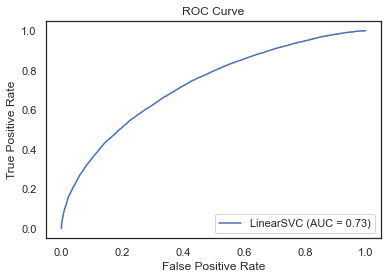

[[15637  7315]
 [ 6599 11928]]
              precision    recall  f1-score   support

         0.0       0.70      0.68      0.69     22952
         1.0       0.62      0.64      0.63     18527

    accuracy                           0.66     41479
   macro avg       0.66      0.66      0.66     41479
weighted avg       0.67      0.66      0.67     41479

Wall time: 4.07 s


In [15]:
%%time
vect, model, X = lsvc_best_run(lsvc_best, len(df))

## LinearSVC, Review features

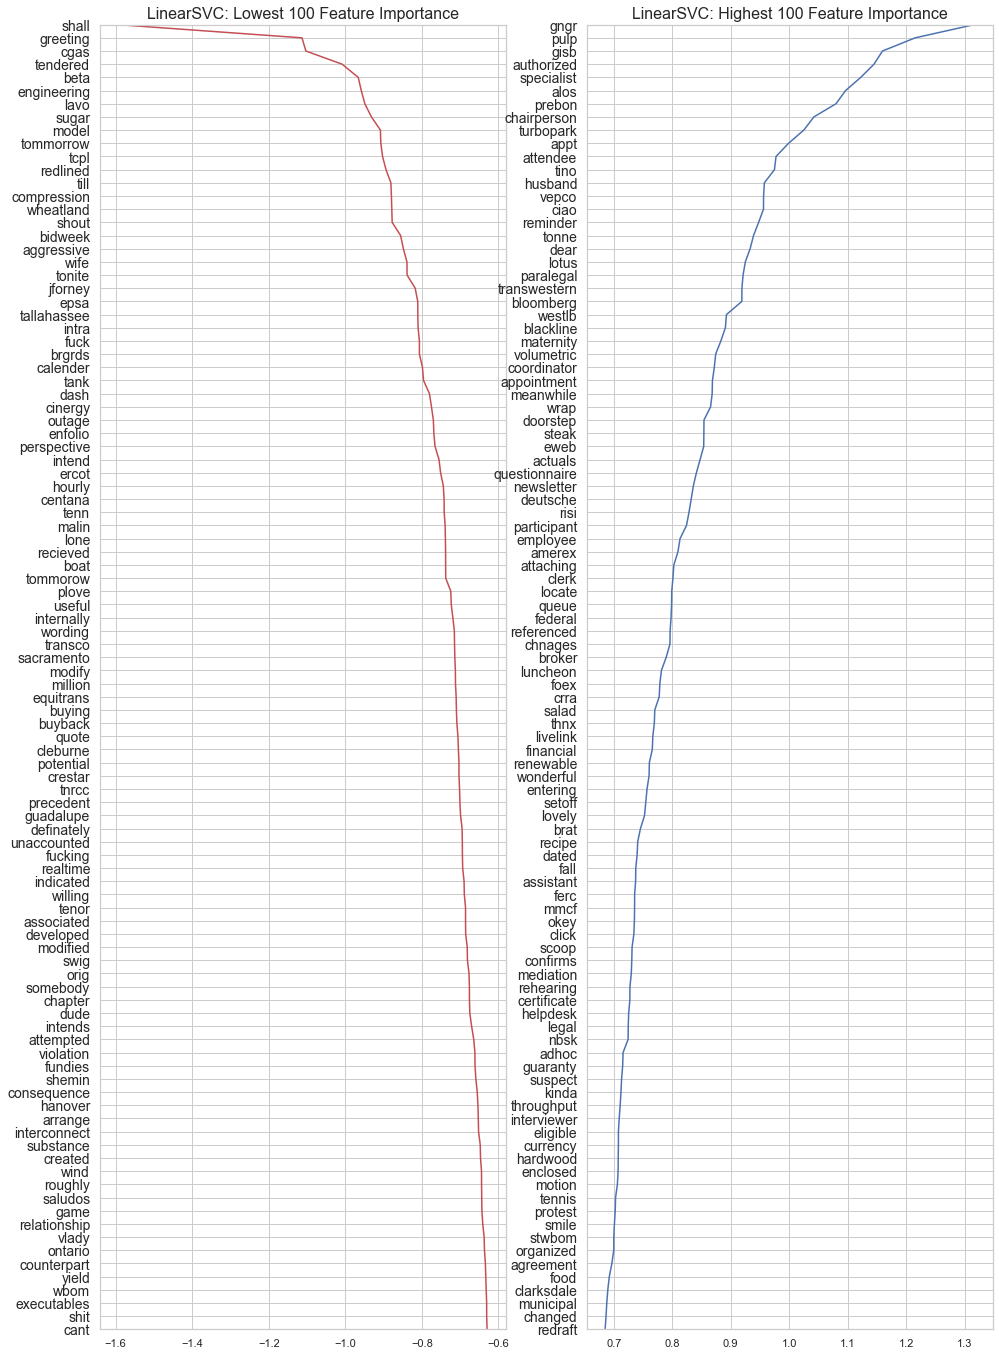


        feature_name  feature_score
4824            gngr       1.316324
8601            pulp       1.215658
4801            gisb       1.159691
840       authorized       1.145185
10280     specialist       1.122533
381             alos       1.096616
8268          prebon       1.080208
1756     chairperson       1.042380
11507      turbopark       1.025146
610             appt       0.999077
795         attendee       0.977617
11225           tino       0.974941
5353         husband       0.957664
11873          vepco       0.956316
1870            ciao       0.956171
9146        reminder       0.947856
11269          tonne       0.939169
2848            dear       0.933287
6434           lotus       0.925117
7758       paralegal       0.921237
11414   transwestern       0.919283
1203       bloomberg       0.919132
12115         westlb       0.892830
1165       blackline       0.890970
6634       maternity       0.883246
11974     volumetric       0.874395
2525     coordinator       

In [16]:
visualizer(vect, model, X, list_n=100)

# Logistic regression (logreg): GridSearchCV

In [17]:
def logreg_gridsearchcv(df, n=5000, cv_n=10, test_size=0.3, random_state=random_state):

    X = df[Corpus_series].values[:n]
    y = df[Target_series].values[:n]
    
    # setup pipeline
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline
    steps = [
        ('vect', TfidfVectorizer()),
        ('logreg', LogisticRegression()),
    ]
    pipeline = Pipeline(steps)

    # Create the hyperparameter grid
    c_space = np.logspace(-5,4, 10)
    parameters = {
        'vect__min_df':[7],
        'vect__max_df':[.7],
        'vect__token_pattern':[r"\w{4,13}"],
        'vect__stop_words':[None],
#        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': c_space, 
#        'logreg__tol':[1e-4],
        'logreg__class_weight':['balanced'],
        'logreg__solver': ['liblinear','saga'],
        'logreg__max_iter':[1000],
    }
    # train, fit, predict
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = GridSearchCV(pipeline, param_grid=parameters, cv=cv_n, n_jobs=-1)
    model.fit(X_train, y_train)

    # print, return params
    print('Tuned Logreg Parameters: {}'.format(model.best_params_))
    print('Tuned Logreg Accuracy: {}'.format(model.best_score_))
    
    return model.best_params_


def logreg_best_run(logreg_best, n=5000, test_size=0.3, random_state=random_state):
    
    X = df[Corpus_series].values[:n]
    y = df[Target_series].values[:n]
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(
        min_df=lsvc_best['vect__min_df'],
        max_df=lsvc_best['vect__max_df'],
        token_pattern=lsvc_best['vect__token_pattern'],
        stop_words=lsvc_best['vect__stop_words'],
    )
    X = vect.fit_transform(X)
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(
#        penalty=logreg_best['logreg__penalty'],
        C=logreg_best['logreg__C'],
#        tol=logreg_best['logreg__tol'],
        class_weight=logreg_best['logreg__class_weight'],
        solver=logreg_best['logreg__solver'],
        max_iter=logreg_best['logreg__max_iter'],
    )
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    from sklearn.metrics import plot_roc_curve
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    plt.title('ROC Curve')
    plot_roc_curve(model, X_test, y_test, ax=ax)
    plt.show()
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return vect, model, X

In [18]:
%%time
n = int(len(df)*.3)
logreg_best = logreg_gridsearchcv(df, n=n)

Tuned Logreg Parameters: {'logreg__C': 1.0, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 1000, 'logreg__solver': 'liblinear', 'vect__max_df': 0.7, 'vect__min_df': 7, 'vect__stop_words': None, 'vect__token_pattern': '\\w{4,13}'}
Tuned Logreg Accuracy: 0.6402151664137696
Wall time: 1min 23s


## Logreg, run optimized parameters

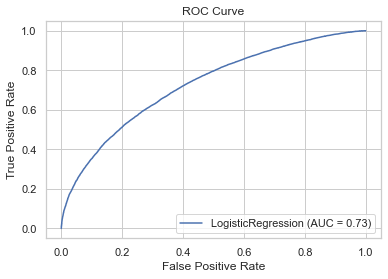

[[15594  7358]
 [ 6573 11954]]
              precision    recall  f1-score   support

         0.0       0.70      0.68      0.69     22952
         1.0       0.62      0.65      0.63     18527

    accuracy                           0.66     41479
   macro avg       0.66      0.66      0.66     41479
weighted avg       0.67      0.66      0.66     41479

Wall time: 4.57 s


In [19]:
%%time
vect, model, X = logreg_best_run(logreg_best, len(df))

## Logreg, Review features

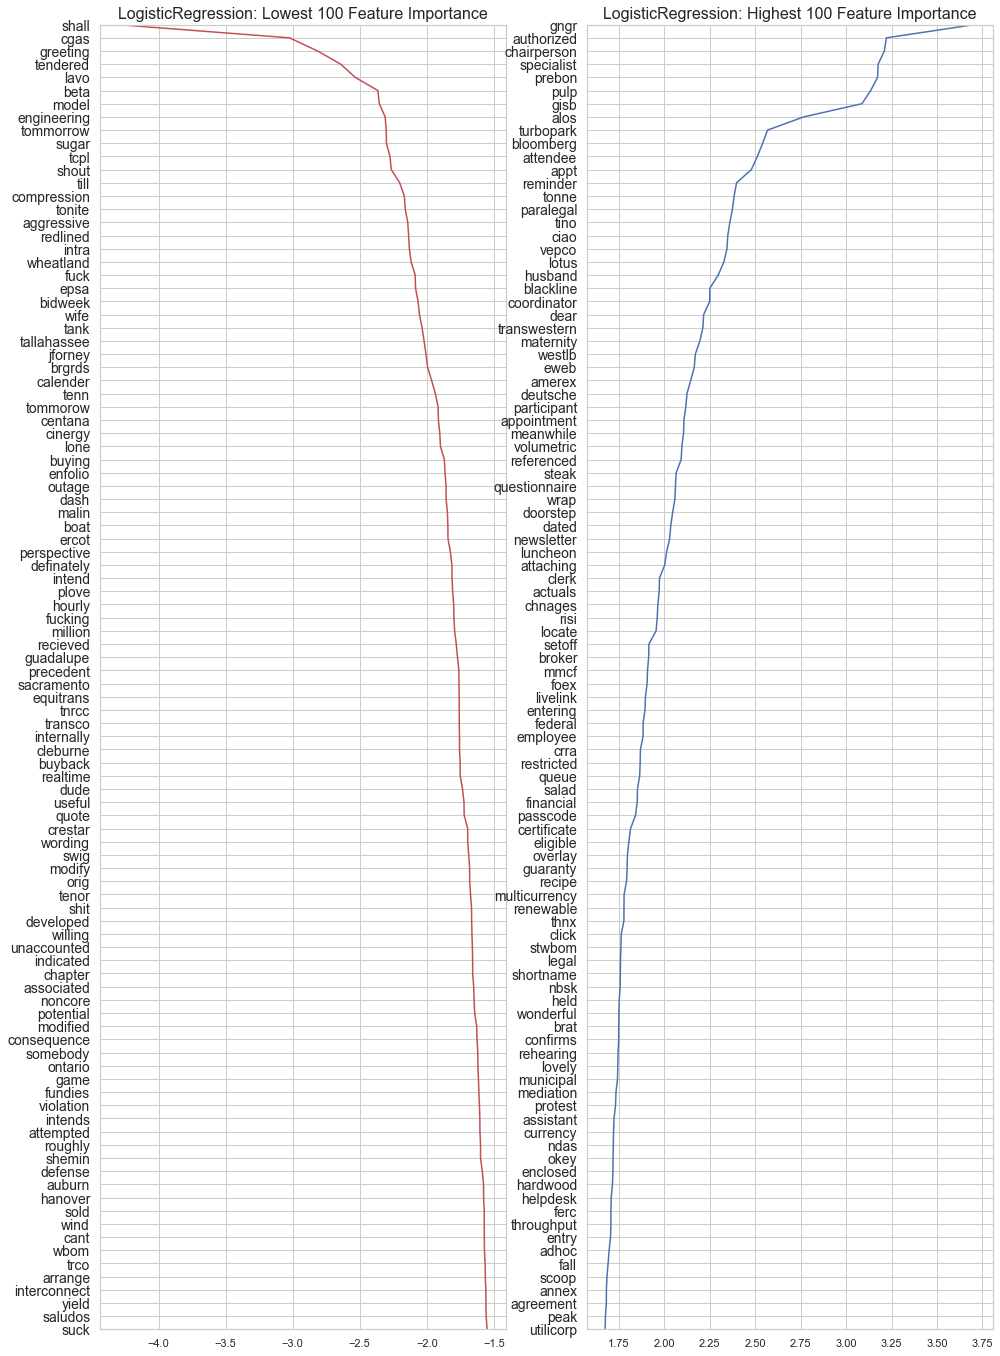


        feature_name  feature_score
4824            gngr       3.703632
840       authorized       3.221948
1756     chairperson       3.210537
10280     specialist       3.176549
8268          prebon       3.173321
8601            pulp       3.135472
4801            gisb       3.087448
381             alos       2.767309
11507      turbopark       2.568755
1203       bloomberg       2.541906
795         attendee       2.512916
610             appt       2.479494
9146        reminder       2.398403
11269          tonne       2.385105
7758       paralegal       2.375713
11225           tino       2.361664
1870            ciao       2.350239
11873          vepco       2.345728
6434           lotus       2.328777
5353         husband       2.297754
1165       blackline       2.251751
2525     coordinator       2.251022
2848            dear       2.217683
11414   transwestern       2.213307
6634       maternity       2.196867
12115         westlb       2.172032
4030            eweb       

In [20]:
visualizer(vect, model, X, list_n=100)

# End Section

In [21]:
end_time = time.perf_counter()
print('Run time: %.1fs (~%dm)' % ((end_time-start_time, (end_time-start_time)/60)))

Run time: 433.0s (~7m)
